### Basic Setting

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from forecaster.data.data_preprocessor import DataPreprocessor

warnings.filterwarnings("ignore")


### Data Preparation
- Retrieve the prediction results and historical data for two months: '2020/01' and '2021/01'.

In [2]:
full_data_pdf = DataPreprocessor("../data/sources/users.csv", "../data/sources/transactions.csv", "../data/sources/stores.csv", is_negative_sampling=False).process()
full_data_pdf["date"] = pd.to_datetime(full_data_pdf['event_occurrence']).dt.strftime('%Y%m%d')
full_data_pdf =  full_data_pdf.rename(columns={"amount": "gmv"})
data_202001_pdf = full_data_pdf[(full_data_pdf["event_occurrence"] >= "20200101") & (full_data_pdf["event_occurrence"] <= "20200131")]
data_202101_pdf = full_data_pdf[(full_data_pdf["event_occurrence"] >= "20210101") & (full_data_pdf["event_occurrence"] <= "20210131")]

predicted_daily_gmv_pdf = pd.read_csv("../results/daily_gmv_20220101_20220131.csv")
predicted_user_gmv_pdf = pd.read_csv("../results/user_gmv_20220101_20220131.csv")


# Label
data_202001_pdf["label"] = "2020-Jan"
data_202101_pdf["label"] = "2021-Jan"
predicted_daily_gmv_pdf["label"] = "Predicted 2022-Jan"
predicted_user_gmv_pdf["label"] = "Predicted 2022-Jan"


In [3]:
user_2020_gmv_pdf = data_202001_pdf.groupby(["label", "user_id"])["gmv"].sum().reset_index()
daily_2020_gmv_pdf = data_202001_pdf.groupby(["label", "date"])["gmv"].sum().reset_index()

user_2021_gmv_pdf = data_202101_pdf.groupby(["label", "user_id"])["gmv"].sum().reset_index()
daily_2021_gmv_pdf = data_202101_pdf.groupby(["label", "date"])["gmv"].sum().reset_index()

In [4]:
# Merge Daily GMV
merged_daily_gmv_pdf = pd.concat([daily_2020_gmv_pdf, daily_2021_gmv_pdf, predicted_daily_gmv_pdf])
merged_daily_gmv_pdf['month_day'] =  pd.to_datetime(merged_daily_gmv_pdf['date']).dt.strftime('%m-%d')

# Merrge User GMV
merged_user_gmv_pdf = pd.concat([user_2020_gmv_pdf, user_2021_gmv_pdf, predicted_user_gmv_pdf])

## Visualize Daily GMV
- Compare the predicted trend with historical time series data.
- The predicted trend appears to be rougher compared to the other two historical trends. This discrepancy may arise from the lack of realistic previous day input for context features.

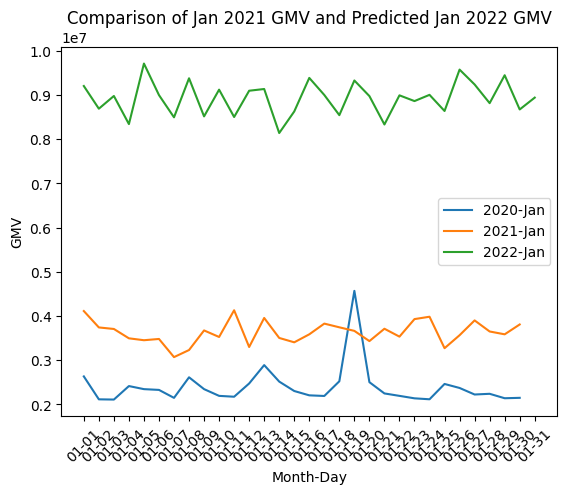

In [5]:
import matplotlib.pyplot as plt

# Iterate over unique labels and plot corresponding time series
for label in merged_daily_gmv_pdf['label'].unique():
    subset = merged_daily_gmv_pdf[merged_daily_gmv_pdf['label'] == label]
    plt.plot(subset['month_day'], subset['gmv'], label=label)

# Add labels and title
plt.xlabel('Month-Day')
plt.ylabel('GMV')
plt.title('Comparison of Jan 2021 GMV and Predicted Jan 2022 GMV')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show legend
plt.legend()

# Show plot
plt.show()


## Visualize User GMV
- The median monthly user GMV of the prediction closely aligns with the historical data but exhibits larger variation.
- The statistical coherence of the results is evident.
- For more detailed comparisons on a per-user basis, further analysis can be conducted if needed.

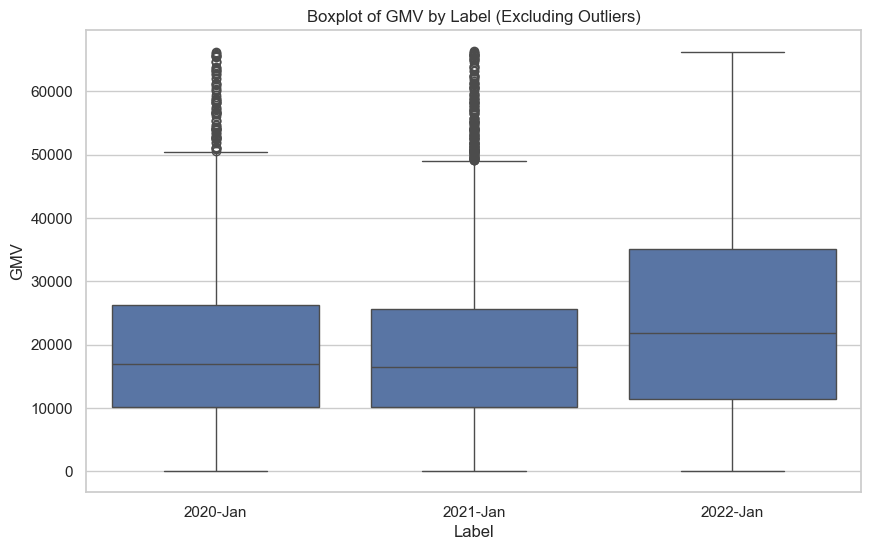

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set plot style
sns.set(style="whitegrid")

# Define the whiskers range to exclude outliers (e.g., 1.5 times the interquartile range)
whisker_range = 1.5

# Calculate the quartiles
q1 = merged_user_gmv_pdf['gmv'].quantile(0.25)
q3 = merged_user_gmv_pdf['gmv'].quantile(0.75)

# Calculate the interquartile range (IQR)
iqr = q3 - q1

# Define the upper and lower whiskers
lower_whisker = q1 - whisker_range * iqr
upper_whisker = q3 + whisker_range * iqr

# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_user_gmv_pdf[(merged_user_gmv_pdf['gmv'] >= lower_whisker) & (merged_user_gmv_pdf['gmv'] <= upper_whisker)], x='label', y='gmv')

# Add labels and title
plt.xlabel('Label')
plt.ylabel('GMV')
plt.title('Boxplot of GMV by Label (Excluding Outliers)')

# Show plot
plt.show()
